# Analyze docking and molecular dynamics results and generate figure plots

## Imports and Constants

In [1]:
import os
import warnings
from collections import defaultdict
from glob import glob
import biotite.structure as struc
import biotite.structure.io as strucio
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import MDAnalysis as mda
from MDAnalysis.analysis import align, diffusionmap
from sklearn.cluster import KMeans
import numpy as np
from pymol import cmd

# Modify the default style of the plots
sns.set(font_scale=1)
sns.set_style("white")

/home/azamh/miniconda3/envs/acyl/lib/python3.11/site-packages/MDAnalysis/topology/TPRParser.py:161: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  import xdrlib


In [2]:
# List of proteins
PROTEINS = [
    "anc451",
    "anc452",
    "anc454",
    "caze",
]

# List of colors for each protein
COLORS = [
    "#00a6a1",
    "#1f8290",
    "#3c596b",
    "#ace18e",
]

# Protein segname
PROT_SEGNAME = "PROA"

# 5CThioester resname and segname
C5_RESNAME = "5CT"
C5_SEGNAME = "5CT1"

# Ancestor substrate resname and segname
ANC_RESNAME = "ANC"
ANC_SEGNAME = "ANC1"

In [3]:
# List of histidine 172 numbering
HISTIDINE_172_RESIS = {
    "anc451": 166,
    "anc452": 169,
    "anc454": 166,
    "caze": 172,
}

# Histidine 172 nitrogen
HISTIDINE_172_NITROGEN = "NE2"

# Ligand Oxygen
LIGAND_OXYGEN = "O2"

# 5CThioester carboynl
C5_CARBONYL_CARBON = "C12"
C5_CARBONYL_OXYGEN = "O8"

## Docking Analysis

In [4]:
def get_top_cluster_poses(dockresult_dir: str):
    """Retrieve the top clustered ligand poses from the docking result directory.

    Args:
    - dockresult_dir (str): The directory containing the docking results.
    """

    # Check whether the results are for rigid docking or flexible docking
    rcdocker_cluster_dir = os.path.join(dockresult_dir, "cluster")
    fcdocker_cluster_dir = os.path.join(dockresult_dir, "cluster/ligand")
    cluster_dir = fcdocker_cluster_dir
    if not os.path.exists(cluster_dir):
        cluster_dir = rcdocker_cluster_dir

    # Get the top cluster poses
    poses = glob(f"{cluster_dir}/top_*.pdb")
    poses = sorted(poses, key=lambda x: int(x.split("_")[-1].split(".")[0]))

    return poses

In [5]:
# Retrieve receptor structures used for docking
dock_receptors = [
    f"../add_5cthioester/5cthioester/{protein}_5cthioester.pdb" for protein in PROTEINS
]

# List of docking strategies
strategies = ["rcdocker", "fcdocker", "fcdocker_flexible_5cthioester"]

# Retrieve ligand poses for each docking strategy
dock_poses = defaultdict(dict)

for strategy in strategies:
    strategy_dir = f"../{strategy}/{strategy}_results"
    for protein in PROTEINS:
        dockresult_dir = (
            f"{strategy_dir}/{protein}_5cthioester_anc_substrate/dockresult"
        )
        dock_poses[strategy][protein] = get_top_cluster_poses(dockresult_dir)

In [6]:
# Get distance between ligand oxygen and carboynl carbon for each docking pose
def get_ligand_carbonyl_dist(
    receptor_pdb,
    ligand_pdb,
):

    # Read structure with biotite
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        receptor_structure = strucio.load_structure(receptor_pdb)
        ligand_structure = strucio.load_structure(ligand_pdb)

    # Get structure of ligand oxygen
    ligand_oxygen_structure = ligand_structure[
        ligand_structure.atom_name == LIGAND_OXYGEN
    ]

    # Get structure of prosthetic group carbonyl carbon
    c5_carbon_structure = receptor_structure[
        (receptor_structure.atom_name == C5_CARBONYL_CARBON)
        & (receptor_structure.res_name == C5_RESNAME)
    ]

    # Get distance between ligand oxygen and carboynl carbon
    carbonyl_oxy_dist = struc.distance(
        ligand_oxygen_structure,
        c5_carbon_structure,
    )

    return carbonyl_oxy_dist[0]


# Build a dataframe with the distance between ligand oxygen and carboynl carbon for each docking pose, protein, and docking strategy
dock_data = []
for strategy in strategies:
    for protein in PROTEINS:
        for pose in dock_poses[strategy][protein]:
            carbonyl_oxy_dist = get_ligand_carbonyl_dist(
                dock_receptors[PROTEINS.index(protein)],
                pose,
            )
            dock_data.append(
                {
                    "strategy": strategy,
                    "protein": protein,
                    "pose": pose,
                    "carbonyl_oxy_dist": carbonyl_oxy_dist,
                }
            )

dock_df = pd.DataFrame(dock_data)
dock_df

,strategy,protein,pose,carbonyl_oxy_dist
0,rcdocker,anc451,../rcdocker/rcdocker_results/anc451_5cthioeste...,8.923352
1,rcdocker,anc451,../rcdocker/rcdocker_results/anc451_5cthioeste...,7.545372
2,rcdocker,anc451,../rcdocker/rcdocker_results/anc451_5cthioeste...,8.268691
3,rcdocker,anc451,../rcdocker/rcdocker_results/anc451_5cthioeste...,11.104248
4,rcdocker,anc451,../rcdocker/rcdocker_results/anc451_5cthioeste...,10.483904
...,...,...,...,...
153,fcdocker_flexible_5cthioester,caze,../fcdocker_flexible_5cthioester/fcdocker_flex...,10.268963
154,fcdocker_flexible_5cthioester,caze,../fcdocker_flexible_5cthioester/fcdocker_flex...,10.038149
155,fcdocker_flexible_5cthioester,caze,../fcdocker_flexible_5cthioester/fcdocker_flex...,8.730351
156,fcdocker_flexible_5cthioester,caze,../fcdocker_flexible_5cthioester/fcdocker_flex...,10.265694


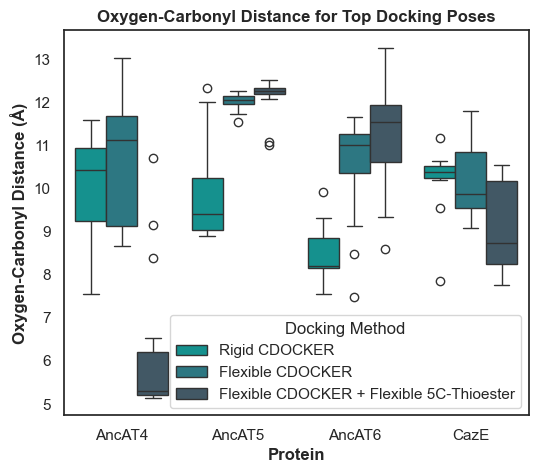

In [47]:
# Create figure plot

# Rename docking methods
plot_df = dock_df.copy()
plot_df["strategy"] = plot_df["strategy"].replace(
    {
        "rcdocker": "Rigid CDOCKER",
        "fcdocker": "Flexible CDOCKER",
        "fcdocker_flexible_5cthioester": "Flexible CDOCKER + Flexible 5C-Thioester",
    }
)

# Rename proteins
plot_df["protein"] = plot_df["protein"].replace(
    {
        "anc451": "AncAT4",
        "anc452": "AncAT5",
        "anc454": "AncAT6",
        "caze": "CazE",
    }
)

plt.figure(figsize=(6, 5))
sns.boxplot(
    data=plot_df,
    x="protein",
    y="carbonyl_oxy_dist",
    hue="strategy",
    palette={
        "Rigid CDOCKER": COLORS[0],
        "Flexible CDOCKER": COLORS[1],
        "Flexible CDOCKER + Flexible 5C-Thioester": COLORS[2],
    },
)


plt.xlabel("Protein", weight="bold")
plt.ylabel("Oxygen-Carbonyl Distance (Å)", weight="bold")
plt.title("Oxygen-Carbonyl Distance for Top Docking Poses", weight="bold")
plt.legend(title="Docking Method", loc="lower right")
plt.savefig("oxygen_carbonyl_distance.png", dpi=300, bbox_inches="tight")

## Dynamics Analysis

In [8]:
# Directory with dynamics results
dyn_dir = "../dyn/dyn"

# Directory with psf files
psf_dir = "../dyn/solvate/solvated_structures"

# Get all universe objects for each protein
universes = {}
for protein in PROTEINS:
    psf_file = f"{psf_dir}/{protein}_5cthioester_anc_substrate.psf"
    dcd_file = f"{dyn_dir}/{protein}_5cthioester_anc_substrate/dyn.dcd"
    universes[protein] = mda.Universe(psf_file, dcd_file)

/home/azamh/miniconda3/envs/acyl/lib/python3.11/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


In [9]:
# Compute nucleophilic attack angle and distance
def compute_nuc(protein: str, u: mda.Universe):
    """
    Compute nucleophilic attack angle and distance for each frame in the trajectory.

    Args:
    - protein (str): Protein name
    - u (MDAnalysis.Universe): Universe object

    """

    def angle_between_two_vecs(x, y):
        """Compute angle between two vectors"""
        return np.arccos(np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y)))

    def angle_between_two_planes(x, y):
        """Compute angle between two planes defined by normal vectors"""
        return np.arccos(np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y)))

    # Define selections

    # Ligand oxygen
    lig_sel = f"resname {ANC_RESNAME} and name {LIGAND_OXYGEN}"
    lig_atom = u.select_atoms(lig_sel, updating=True)

    # 5CThioester carbonyl carbon
    c5_sel = f"resname {C5_RESNAME} and name {C5_CARBONYL_CARBON}"
    c5_atom = u.select_atoms(c5_sel, updating=True)

    # 5CThioester carbonyl oxygen
    c5_oxy_sel = f"resname {C5_RESNAME} and name {C5_CARBONYL_OXYGEN}"
    c5_oxy_atom = u.select_atoms(c5_oxy_sel, updating=True)

    # Histidine 172 nitrogen
    his_sel = f"resid {HISTIDINE_172_RESIS[protein]} and name {HISTIDINE_172_NITROGEN}"
    his_atom = u.select_atoms(his_sel, updating=True)

    # Store measurements
    measurements = {}

    # Loop over frames
    for frame, ts in enumerate(u.trajectory):

        # Store positions for carbonyl carbon (C), carbonyl oxygen (O), and nucleophile (N)
        C = c5_atom.positions[0]
        O = c5_oxy_atom.positions[0]
        N = lig_atom.positions[0]
        H = his_atom.positions[0]

        CO_vector = C - O
        NC_vector = N - C

        # Compute Bürgi–Dunitz angle
        bd_angle = angle_between_two_vecs(NC_vector, CO_vector)

        # Compute distance between nucleophile and carbonyl carbon
        nuc_carb_dist = np.linalg.norm(N - C)

        # Compute distance between nucleophile and histidine 172 nitrogen
        nuc_his_dist = np.linalg.norm(N - H)

        # Store measurements
        measurements[frame] = {
            "bd_angle": np.degrees(bd_angle),
            "nuc_carb_dist": nuc_carb_dist,
            "nuc_his_dist": nuc_his_dist,
            "Protein": protein,
        }

    # Convert to dataframe
    df = pd.DataFrame(measurements).T

    return df


# Compute nucleophilic attack angle and distance for each protein
nuc_dfs = [compute_nuc(protein, u) for protein, u in universes.items()]
nuc_df = pd.concat(nuc_dfs)
nuc_df

,bd_angle,nuc_carb_dist,nuc_his_dist,Protein
0,128.212372,6.371756,5.312216,anc451
1,129.741943,6.250637,5.815598,anc451
2,125.870819,6.867115,5.371814,anc451
3,120.398224,6.410408,5.784691,anc451
4,132.404907,6.152549,5.37697,anc451
...,...,...,...,...
495,141.0215,9.055449,4.689445,caze
496,146.599655,8.994858,4.679032,caze
497,124.491119,9.106721,4.414865,caze
498,133.810654,9.077816,4.450055,caze


In [10]:
# Print frames with BD angle between 90 and 107.5 degrees and distance less than 6 Å
near_attack_df = nuc_df[
    (nuc_df.bd_angle >= 90) & (nuc_df.bd_angle <= 107.5) & (nuc_df.nuc_carb_dist <= 6)
].sort_values(["nuc_carb_dist"])

# Print fraction of frames with BD angle between 90 and 107.5 degrees for each protein
for protein in PROTEINS:
    protein_near_attack_df = near_attack_df[near_attack_df.Protein == protein]
    print(
        f"{protein}: {protein_near_attack_df.shape[0] / nuc_df[nuc_df.Protein == protein].shape[0]:.2f}"
    )

display(near_attack_df)

anc451: 0.02
anc452: 0.00
anc454: 0.00
caze: 0.00


,bd_angle,nuc_carb_dist,nuc_his_dist,Protein
393,101.999435,5.312741,3.942589,anc451
414,105.537437,5.602772,6.031926,anc451
394,105.765701,5.622621,4.077013,anc451
350,105.066528,5.707235,5.58173,anc451
379,102.799187,5.795238,3.926956,anc451
349,107.492447,5.803599,3.984408,anc451
372,107.425438,5.834861,3.506756,anc451
384,106.308693,5.883783,4.718863,anc451
364,104.176529,5.891704,4.538201,anc451
368,103.855957,5.958328,4.292362,anc451


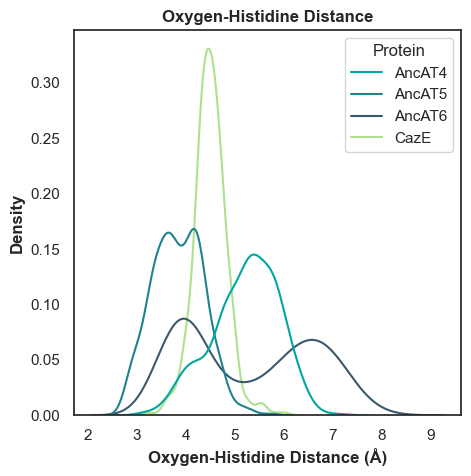

In [49]:
# Plot dynamics results
plot_df = nuc_df.copy()

# Rename proteins
plot_df["Protein"] = plot_df["Protein"].replace(
    {
        "anc451": "AncAT4",
        "anc452": "AncAT5",
        "anc454": "AncAT6",
        "caze": "CazE",
    }
)


# Plot histogram of nucleophile histidine distance
plt.figure(figsize=(5, 5))
sns.kdeplot(
    data=plot_df,
    x="nuc_his_dist",
    hue="Protein",
    palette={
        "AncAT4": COLORS[0],
        "AncAT5": COLORS[1],
        "AncAT6": COLORS[2],
        "CazE": COLORS[3],
    },
)
plt.xlabel("Oxygen-Histidine Distance (Å)", weight="bold")
plt.ylabel("Density", weight="bold")
plt.title("Oxygen-Histidine Distance", weight="bold")
# plt.legend(title="Protein", loc="upper right")
plt.savefig("oxygen_histidine_distance.png", dpi=300, bbox_inches="tight")

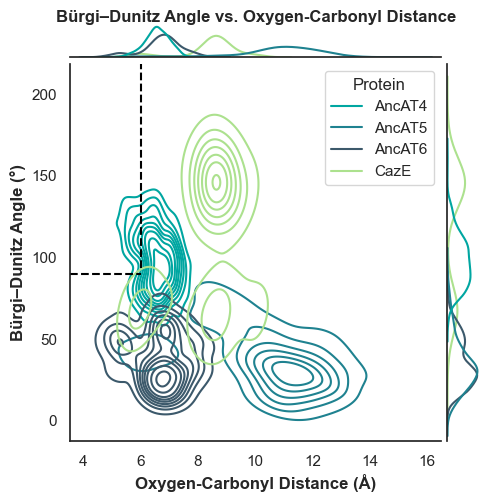

In [50]:
# Plot joint plot of bd_angle and nuc_carb_dist
sns.jointplot(
    data=plot_df,
    x="nuc_carb_dist",
    y="bd_angle",
    hue="Protein",
    kind="kde",
    height=5,
    ratio=10,
    palette={
        "AncAT4": COLORS[0],
        "AncAT5": COLORS[1],
        "AncAT6": COLORS[2],
        "CazE": COLORS[3],
    },
)

# Add dashed lines for cutoffs
plt.axhline(90, color="black", linestyle="--", xmax=0.19)
plt.axvline(6, color="black", linestyle="--", ymin=0.46)

plt.xlabel("Oxygen-Carbonyl Distance (Å)", weight="bold")
plt.ylabel("Bürgi–Dunitz Angle (°)", weight="bold")
plt.title("Bürgi–Dunitz Angle vs. Oxygen-Carbonyl Distance", weight="bold", pad=30)
plt.savefig("nucleophilic_attack.png", dpi=300, bbox_inches="tight")

## Visuallize complex

In [13]:
def save_closest_frame_to_largest_cluster_centroid(
    u: mda.Universe,
    savefile: str,
    n_clusters=8,
):
    """
    Extract the frame closest to the centroid of the largest cluster and save it as a PDB file.

    Args:
    - u (mda.Universe): MDAnalysis Universe object.
    - savefile (str): Path to save the PDB file.
    - n_clusters (int): Number of clusters to use for clustering.

    """

    # Align the trajectory to the reference frame
    # Assuming the reference is the first frame, but can be adjusted
    ref = u.copy()
    aligner = align.AlignTraj(u, ref, select="name CA", in_memory=True).run()

    # Select the ligand
    ligand = u.select_atoms(f"resname {ANC_RESNAME}")

    # Compute the RMSD matrix for ligand
    matrix = (
        diffusionmap.DistanceMatrix(u, select=f"resname {ANC_RESNAME}")
        .run()
        .results.dist_matrix
    )

    # Perform clustering
    kmeans = KMeans(n_clusters=n_clusters)
    clusters = kmeans.fit_predict(matrix)

    # Identify the largest cluster
    largest_cluster = np.argmax(np.bincount(clusters))

    # Calculate the centroid of the largest cluster
    largest_cluster_indices = np.where(clusters == largest_cluster)[0]
    centroid_of_largest = np.mean(matrix[largest_cluster_indices], axis=0)

    # Find the frame closest to the centroid of the largest cluster
    distances = np.linalg.norm(matrix - centroid_of_largest, axis=1)
    closest_frame_index = np.argmin(distances)

    # Extract and save this frame as a PDB file
    u.trajectory[closest_frame_index]

    # Select all atoms
    all_atoms = u.select_atoms("all")
    all_atoms.write(savefile)


# Get near attack structure for AncAT4
frame_idx = (
    near_attack_df[near_attack_df.Protein == "anc451"]
    .sort_values("nuc_carb_dist")
    .head(1)
    .index[0]
)
print(frame_idx)
print(near_attack_df.loc[frame_idx])

# Save the near attack structure for AncAT4
u = universes["anc451"]
u.trajectory[frame_idx]
all_atoms = u.select_atoms("all")
all_atoms.write("anc451_near_attack.pdb")

393
bd_angle         101.999435
nuc_carb_dist      5.312741
nuc_his_dist       3.942589
Protein              anc451
Name: 393, dtype: object


/home/azamh/miniconda3/envs/acyl/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/home/azamh/miniconda3/envs/acyl/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/home/azamh/miniconda3/envs/acyl/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning: Found no information for attr: 'chainIDs' Using default value of ''
  warnings.warn("Found no information for attr: '{}'"
/home/azamh/miniconda3/envs/acyl/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  warnings.warn("Found no information for attr: '{}'"
/home/azamh/miniconda3/envs/acyl/lib/python3.11/site-packages/M

In [14]:
def visuallize_complex(protein, pdb_file, savefile):
    """
    Visualize the complex with PyMOL.
    The png + ray takes ~15 minutes.
    For faster images hide cartoon.

    Args:
    - protein (str): Protein name.
    - pdb_file (str): Path to the PDB file.
    - savefile (str): Path to save the image.

    """

    def modify_color(color):
        """Modify color to be compatible with PyMOL"""
        return "0x" + color[1:]

    cmd.reinitialize()

    # Load the complex
    cmd.load(pdb_file, "Complex")

    # Remove waters
    cmd.remove("resn TIP3")

    # Remove ions
    cmd.remove("resn CLA")

    # Set background color to white
    cmd.bg_color("white")

    # Show cartoon
    # cmd.hide("cartoon")
    cmd.show("cartoon")
    cmd.set("cartoon_transparency", 0.7)

    # Set labels
    his_resi = HISTIDINE_172_RESIS[protein]
    histidine_label_sel = f"resi {his_resi} and name HB2"
    cmd.label(histidine_label_sel, f'"H{his_resi}"')

    cmd.label(f"resn {ANC_RESNAME} and name H13", f'"(S)-12"')

    cmd.label(f"resn {C5_RESNAME} and name H33", f'"C5-Thioester"')

    cmd.set("label_position", (0.7, 0.95, 20))
    cmd.set("label_size", 20)
    cmd.set("label_font_id", 7)

    # Set colors
    protein_color = modify_color(COLORS[-1])
    cmd.color(protein_color, "complex and elem C")

    ligand_color = modify_color(COLORS[0])
    cmd.color(ligand_color, f"resn {ANC_RESNAME} and elem C")

    c5thioester_color = modify_color(COLORS[2])
    cmd.color(c5thioester_color, f"resn {C5_RESNAME} and elem C")

    # Show sticks for histidine 172
    cmd.show("sticks", f"resi {HISTIDINE_172_RESIS[protein]}")

    # Set distances
    cmd.distance(
        "dist1",
        f"resn {ANC_RESNAME} and name {LIGAND_OXYGEN}",
        f"resn {C5_RESNAME} and name {C5_CARBONYL_CARBON}",
    )

    cmd.distance(
        "dist2",
        f"resn {ANC_RESNAME} and name {LIGAND_OXYGEN}",
        f"resi {HISTIDINE_172_RESIS[protein]} and name {HISTIDINE_172_NITROGEN}",
    )

    # Set view
    cmd.set_view(
        (
            0.168330431,
            -0.980758727,
            -0.098858021,
            0.960026801,
            0.185866728,
            -0.209268689,
            0.223620340,
            -0.059679359,
            0.972845495,
            -0.000246858,
            0.000253802,
            -35.272483826,
            56.650177002,
            36.990192413,
            49.369007111,
            -340670.750000000,
            340748.843750000,
            -20.000000000,
        )
    )

    # Save the image
    cmd.png(savefile, 800, 600, dpi=300)

    # Save pymol session
    prefix = os.path.splitext(savefile)[0]
    cmd.save(f"{prefix}.pse")


# Visualize the representative structure
visuallize_complex("anc451", "anc451_near_attack.pdb", "anc451_near_attack.png")